In [33]:
!pip install optuna

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import math
import torch.nn.functional as F
import re
import optuna
from optuna.trial import TrialState
from torch.optim import Adam
import torch.nn.functional as F
from transformers import AutoTokenizer

In [35]:
df = pd.read_csv('/kaggle/input/peptide/data.csv')

In [36]:
df.shape

(134281, 4)

In [37]:
df.sample(5)

,pep,logic,allele,mhc
40439,GYVSLQEFVDLNNKG,0.332226,DRB1_0401,QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT
103335,AIQQVRSLIGNEEFLDY,0.441423,DRB1_1101,QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT
97798,YLGKREDQWCGSLIGLT,0.244351,DRB1_0401,QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT
113520,GATVAVDCRPFNGGE,0.313456,HLA-DQA10102-DQB10602,CNYHQGGGARVAHIMFFGLTYYDVGTETVHVAGI
130136,LSRNSTHEMYYVSGA,0.000000,DRB3_0101,QEFFIASGAAVDAIMERSYDYYVLQKRNYHVGFT


In [38]:
df.isnull().sum()

pep       0
logic     0
allele    0
mhc       0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134281 entries, 0 to 134280
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pep     134281 non-null  object 
 1   logic   134281 non-null  float64
 2   allele  134281 non-null  object 
 3   mhc     134281 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.1+ MB


In [40]:
df.drop(columns=['allele'],inplace=True)
df.sample(5)

,pep,logic,mhc
120231,QNSSFIIDGPNTPEC,0.470770,QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT
17467,LEVLNFDFQANAQLS,0.223495,QEFFIASGAAVDAIMESGFDYYDFDRLTYHVGFT
59213,EKKYFAATQFAPLAA,0.719884,YAFFQFSGGAILNTLFGQFEYFEIEKVRMHLDVT
115801,SKGDSARVTVKDVTF,0.271108,YNYHQRXFATVTHILFFGGTYYDIEDSTVHLETT
100052,QPYVLSVASLTSAGQ,0.184240,QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [42]:
threshold = 0.4256

scoredf = df['logic'].apply(lambda x: 1 if x > threshold else 0)

In [43]:
scoredf.value_counts()

logic
0    78308
1    55973
Name: count, dtype: int64

In [44]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

In [ ]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [48]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [49]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [50]:
vocab_size = len(tokenizer.get_vocab())
print(vocab_size)

33


In [51]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [52]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [53]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [54]:
X = torch.stack((pep_input_ids,mhc_input_ids,pep_attention_mask,mhc_attention_mask),dim=1)
y = torch.tensor(scoredf.values,dtype=torch.float32)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [23]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1],X_val[:,2],X_val[:,3], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],y_test)

In [55]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=39):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.clamp(
            torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim),
            min=-10, max=10
        ))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_heads, num_layers, max_len=39, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim, max_len)
        self.norm = nn.LayerNorm(model_dim)  # LayerNorm
        self.encoder_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
    
    def forward(self, x, padding_mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.norm(x)
        return self.encoder_layers(x, src_key_padding_mask=padding_mask)

class CrossAttentionLayer(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(model_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, pep_refined, mhc_refined):
        attn_output, _ = self.cross_attention(mhc_refined, pep_refined, pep_refined)
        attn_output = self.norm(mhc_refined + self.dropout(attn_output))
        return attn_output

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, model_dim, num_heads, num_layers, dropout=0.1, max_len=39):
        super(TransformerModel, self).__init__()
        self.encoder_pep = TransformerEncoder(vocab_size, model_dim, num_heads, num_layers, max_len, dropout)
        self.encoder_mhc = TransformerEncoder(vocab_size, model_dim, num_heads, num_layers, max_len, dropout)
        self.cross_attention = CrossAttentionLayer(model_dim, num_heads, dropout)  # Use cross-attention
        self.norm_fc1 = nn.LayerNorm(model_dim)
        self.norm_fc2 = nn.LayerNorm(512)
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, pep_input, mhc_input, pep_mask, mhc_mask):
        pep_padding_mask = ~(pep_mask.bool())
        mhc_padding_mask = ~(mhc_mask.bool())
        pep_refined = self.encoder_pep(pep_input, padding_mask=pep_padding_mask)
        mhc_refined = self.encoder_mhc(mhc_input, padding_mask=mhc_padding_mask)
        cross_output = self.cross_attention(pep_refined, mhc_refined)
        x = cross_output.mean(dim=1)
        x = self.norm_fc1(x)
        x = F.gelu(self.fc1(x))
        x = self.norm_fc2(x)
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
def objective(trial):
    #hyperparamas
    model_dim = trial.suggest_categorical("model_dim",[64,128,256,512])
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 1e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-2, 1e-3, 1e-4, 1e-5])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    model = TransformerModel(
        model_dim=model_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=dropout,
        vocab_size=vocab_size
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(5):

        model.train()
        for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in train_loader:
            pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()

            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        total_preds, total_labels = [], []
        with torch.no_grad():
            for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in val_loader:
                pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs).cpu()
                total_preds.append(probs)
                total_labels.append(scores.cpu())

        val_loss /= len(val_loader)

        total_preds = torch.cat(total_preds).numpy()
        total_labels = torch.cat(total_labels).numpy()

        binary_preds = (total_preds > 0.4256).astype(int)

        val_precision = precision_score(total_labels, binary_preds,zero_division=0.0)
        val_recall = recall_score(total_labels, binary_preds,zero_division=0.0)
        val_f1 = f1_score(total_labels, binary_preds,zero_division=0.0)

        val_auroc = roc_auc_score(total_labels, total_preds)

        print(f"Trial Results: Val Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, AUROC: {val_auroc:.4f}")

    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Val Loss: {trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")

[I 2025-02-28 13:56:31,600] A new study created in memory with name: no-name-c9e337b3-bf24-4d8d-aca6-522f128ffdf3


Trial Results: Val Loss: 0.5384, Precision: 0.6436, Recall: 0.7155, F1 Score: 0.6776, AUROC: 0.7907
Trial Results: Val Loss: 0.5135, Precision: 0.6487, Recall: 0.7720, F1 Score: 0.7050, AUROC: 0.8170
Trial Results: Val Loss: 0.5025, Precision: 0.6876, Recall: 0.7226, F1 Score: 0.7047, AUROC: 0.8238
Trial Results: Val Loss: 0.4999, Precision: 0.6689, Recall: 0.7666, F1 Score: 0.7144, AUROC: 0.8281


[I 2025-02-28 14:06:46,454] Trial 0 finished with value: 0.4891719348019078 and parameters: {'model_dim': 512, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'batch_size': 128}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.4892, Precision: 0.6761, Recall: 0.7821, F1 Score: 0.7253, AUROC: 0.8386
Trial Results: Val Loss: 0.6819, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5914
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5820
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5485
Trial Results: Val Loss: 0.6813, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.5716


[I 2025-02-28 14:17:17,307] Trial 1 finished with value: 0.6815987488343602 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.6816, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.4993
Trial Results: Val Loss: 0.6815, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.5789
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5993
Trial Results: Val Loss: 0.6800, Precision: 0.4832, Recall: 0.3774, F1 Score: 0.4238, AUROC: 0.5273
Trial Results: Val Loss: 0.6856, Precision: 0.4440, Recall: 0.4414, F1 Score: 0.4427, AUROC: 0.5482


[I 2025-02-28 14:20:30,044] Trial 2 finished with value: 0.6797886001212257 and parameters: {'model_dim': 64, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'batch_size': 256}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.6798, Precision: 0.5076, Recall: 0.3092, F1 Score: 0.3843, AUROC: 0.5742
Trial Results: Val Loss: 0.5826, Precision: 0.6036, Recall: 0.7012, F1 Score: 0.6488, AUROC: 0.7508
Trial Results: Val Loss: 0.5598, Precision: 0.6538, Recall: 0.6523, F1 Score: 0.6530, AUROC: 0.7760
Trial Results: Val Loss: 0.5734, Precision: 0.5815, Recall: 0.8149, F1 Score: 0.6787, AUROC: 0.7824
Trial Results: Val Loss: 0.5548, Precision: 0.6399, Recall: 0.7028, F1 Score: 0.6699, AUROC: 0.7802


[I 2025-02-28 14:25:34,192] Trial 3 finished with value: 0.5199415339600473 and parameters: {'model_dim': 128, 'num_heads': 8, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'batch_size': 256}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.5199, Precision: 0.6776, Recall: 0.7087, F1 Score: 0.6928, AUROC: 0.8112
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5186
Trial Results: Val Loss: 0.6813, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.5208
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5081
Trial Results: Val Loss: 0.6812, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.4925


[I 2025-02-28 14:40:19,384] Trial 4 finished with value: 0.6813596515428453 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.6814, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5084
Trial Results: Val Loss: 0.6814, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.5677
Trial Results: Val Loss: 0.6817, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5618
Trial Results: Val Loss: 0.6816, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5986
Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5520


[I 2025-02-28 14:42:55,652] Trial 5 finished with value: 0.6822346966891062 and parameters: {'model_dim': 64, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 256}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.6822, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5634
Trial Results: Val Loss: 0.6819, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5745
Trial Results: Val Loss: 0.6813, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.6538
Trial Results: Val Loss: 0.6817, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5612
Trial Results: Val Loss: 0.6821, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.4961


[I 2025-02-28 14:45:23,292] Trial 6 finished with value: 0.6813807278161957 and parameters: {'model_dim': 64, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.6814, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.4519
Trial Results: Val Loss: 0.5922, Precision: 0.5760, Recall: 0.7713, F1 Score: 0.6595, AUROC: 0.7516
Trial Results: Val Loss: 0.5650, Precision: 0.6557, Recall: 0.6574, F1 Score: 0.6566, AUROC: 0.7767
Trial Results: Val Loss: 0.5568, Precision: 0.6165, Recall: 0.7480, F1 Score: 0.6759, AUROC: 0.7796
Trial Results: Val Loss: 0.5510, Precision: 0.6224, Recall: 0.7484, F1 Score: 0.6796, AUROC: 0.7851


[I 2025-02-28 14:47:49,032] Trial 7 finished with value: 0.5456573250038284 and parameters: {'model_dim': 64, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256}. Best is trial 0 with value: 0.4891719348019078.


Trial Results: Val Loss: 0.5457, Precision: 0.6439, Recall: 0.7215, F1 Score: 0.6805, AUROC: 0.7906
Trial Results: Val Loss: 0.5403, Precision: 0.6386, Recall: 0.7296, F1 Score: 0.6811, AUROC: 0.7912
Trial Results: Val Loss: 0.5280, Precision: 0.6733, Recall: 0.6998, F1 Score: 0.6863, AUROC: 0.8027
Trial Results: Val Loss: 0.5065, Precision: 0.6727, Recall: 0.7395, F1 Score: 0.7046, AUROC: 0.8221
Trial Results: Val Loss: 0.4995, Precision: 0.6466, Recall: 0.8189, F1 Score: 0.7226, AUROC: 0.8342


[I 2025-02-28 14:52:43,980] Trial 8 finished with value: 0.4886788268174444 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 256}. Best is trial 8 with value: 0.4886788268174444.


Trial Results: Val Loss: 0.4887, Precision: 0.6934, Recall: 0.7520, F1 Score: 0.7215, AUROC: 0.8364
Trial Results: Val Loss: 0.5384, Precision: 0.6566, Recall: 0.7030, F1 Score: 0.6790, AUROC: 0.7948
Trial Results: Val Loss: 0.5164, Precision: 0.6448, Recall: 0.7692, F1 Score: 0.7015, AUROC: 0.8164
Trial Results: Val Loss: 0.5191, Precision: 0.7268, Recall: 0.6445, F1 Score: 0.6832, AUROC: 0.8176
Trial Results: Val Loss: 0.4946, Precision: 0.6787, Recall: 0.7603, F1 Score: 0.7172, AUROC: 0.8319


[I 2025-02-28 15:07:59,317] Trial 9 finished with value: 0.5030394641771203 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'batch_size': 64}. Best is trial 8 with value: 0.4886788268174444.


Trial Results: Val Loss: 0.5030, Precision: 0.6918, Recall: 0.7350, F1 Score: 0.7127, AUROC: 0.8291
Best trial:
  Val Loss: 0.4887
  Hyperparameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 256}


In [24]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [56]:
model_dim = 256
num_heads = 4
num_layers = 2
dropout = 0.1
model = TransformerModel(vocab_size,model_dim, num_heads, num_layers,dropout=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001,weight_decay=0.001)
epochs = 200

In [26]:
model.to(device)

TransformerModel(
  (encoder_pep): TransformerEncoder(
    (embedding): Embedding(33, 256)
    (positional_encoding): PositionalEncoding()
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (encoder_layers): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (encoder_mhc): TransformerEncoder(
    (emb

In [27]:
patience = 6
best_val_loss = float('inf')
patience_counter = 0
save_path = '/kaggle/working/classificationmodel.pth'
train_losses = []
val_losses = []
train_auroc_list = []
val_auroc_list = []
train_f1_list = []
val_f1_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []

for epoch in range(epochs):
    #train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in train_loader:
        pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds).numpy()
    total_train_labels = torch.cat(total_train_labels).numpy()
    train_auroc = roc_auc_score(total_train_labels, total_train_preds)
    train_f1 = f1_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_precision = precision_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_recall = recall_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)

    train_auroc_list.append(train_auroc)
    train_f1_list.append(train_f1)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, AUC ROC: {train_auroc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

    #val loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in val_loader:
            pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
            outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
            loss = criterion(outputs, scores)
            val_loss += loss.item()
            total_val_preds.append(torch.sigmoid(outputs).cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds).numpy()
    total_val_labels = torch.cat(total_val_labels).numpy()
    val_auroc = roc_auc_score(total_val_labels, total_val_preds)
    val_f1 = f1_score(total_val_labels, total_val_preds > 0.4256)
    val_precision = precision_score(total_val_labels, total_val_preds > 0.4256)
    val_recall = recall_score(total_val_labels, total_val_preds > 0.4256)

    val_auroc_list.append(val_auroc)
    val_f1_list.append(val_f1)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, AUC ROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    #early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with val loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val loss: {best_val_loss:.4f}")
            break


Epoch 1, Train Loss: 0.5730, AUC ROC: 0.7553, F1: 0.6420, Precision: 0.6145, Recall: 0.6721


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1, Val Loss: 0.5523, AUC ROC: 0.7871, F1: 0.6455, Precision: 0.6860, Recall: 0.6094
Best model saved with val loss: 0.5523
Epoch 2, Train Loss: 0.5194, AUC ROC: 0.8093, F1: 0.6890, Precision: 0.6683, Recall: 0.7111
Epoch 2, Val Loss: 0.5277, AUC ROC: 0.8061, F1: 0.6874, Precision: 0.6723, Recall: 0.7032
Best model saved with val loss: 0.5277
Epoch 3, Train Loss: 0.4968, AUC ROC: 0.8281, F1: 0.7059, Precision: 0.6825, Recall: 0.7309
Epoch 3, Val Loss: 0.5070, AUC ROC: 0.8239, F1: 0.7132, Precision: 0.6612, Recall: 0.7741
Best model saved with val loss: 0.5070
Epoch 4, Train Loss: 0.4838, AUC ROC: 0.8384, F1: 0.7169, Precision: 0.6959, Recall: 0.7391
Epoch 4, Val Loss: 0.4969, AUC ROC: 0.8317, F1: 0.7069, Precision: 0.7176, Recall: 0.6966
Best model saved with val loss: 0.4969
Epoch 5, Train Loss: 0.4727, AUC ROC: 0.8468, F1: 0.7248, Precision: 0.7038, Recall: 0.7472
Epoch 5, Val Loss: 0.4948, AUC ROC: 0.8328, F1: 0.7118, Precision: 0.7075, Recall: 0.7162
Best model saved with val 

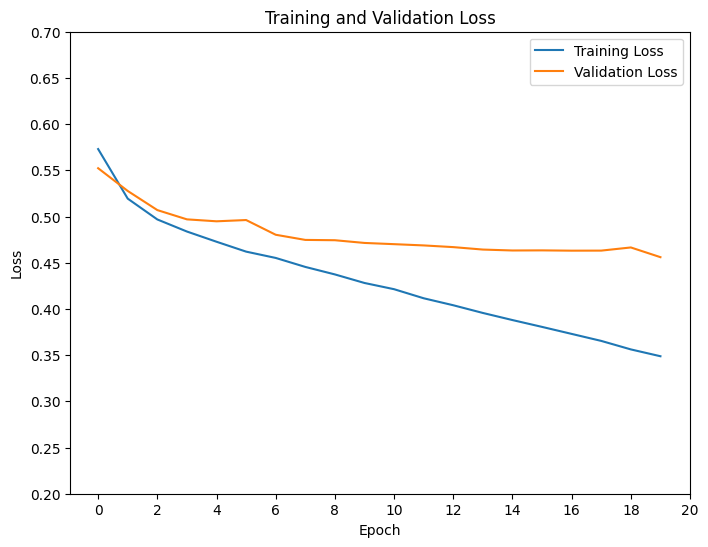

In [49]:
plt.figure(figsize=(8,6))
plt.plot(train_losses[:20], label='Training Loss')
plt.plot(val_losses[:20], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.yticks(np.arange(0.2, 0.75, 0.05))
plt.xticks(np.arange(0, 22, 2))
plt.legend()

In [41]:
save_path = '/kaggle/working/classificationmodel.pth'

In [42]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix)

model.load_state_dict(torch.load(save_path,weights_only=True))
model.eval()
total_test_preds = []
total_test_labels = []
test_loss = 0

with torch.no_grad():
    for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in test_loader:
        pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
        outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
        loss = criterion(outputs, scores)
        test_loss += loss.item()
        total_test_preds.append(torch.sigmoid(outputs).cpu())
        total_test_labels.append(scores.cpu())

test_loss /= len(test_loader)
total_test_preds = torch.cat(total_test_preds).numpy()
total_test_labels = torch.cat(total_test_labels).numpy()
threshold = 0.4256
binary_preds = (total_test_preds >= threshold).astype(int)
test_auroc = roc_auc_score(total_test_labels, total_test_preds)
test_f1 = f1_score(total_test_labels, binary_preds)
test_precision = precision_score(total_test_labels, binary_preds)
test_recall = recall_score(total_test_labels, binary_preds)
print(f"Test Loss: {test_loss:.4f}, AUROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Test Loss: 0.4471, AUROC: 0.8707, F1: 0.7567, Precision: 0.7309, Recall: 0.7844


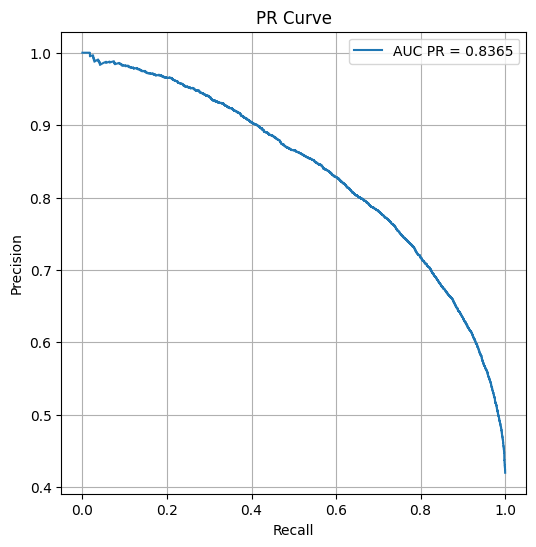

In [43]:
precision, recall, _ = precision_recall_curve(total_test_labels, total_test_preds)
pr_auc = auc(recall, precision)


plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'AUC PR = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

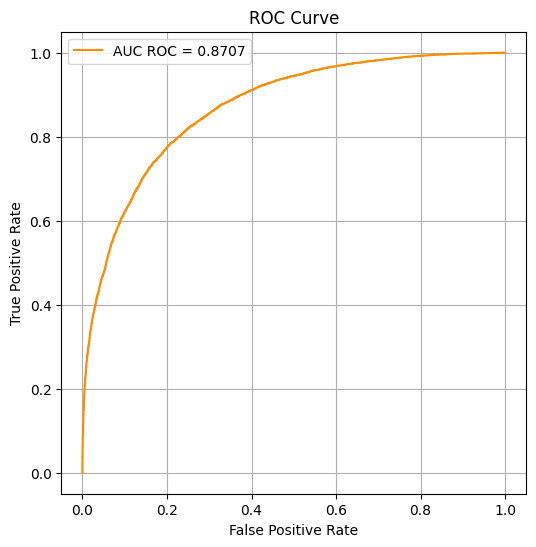

In [44]:
fpr, tpr, _ = roc_curve(total_test_labels, total_test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC ROC = {roc_auc:.4f}', color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

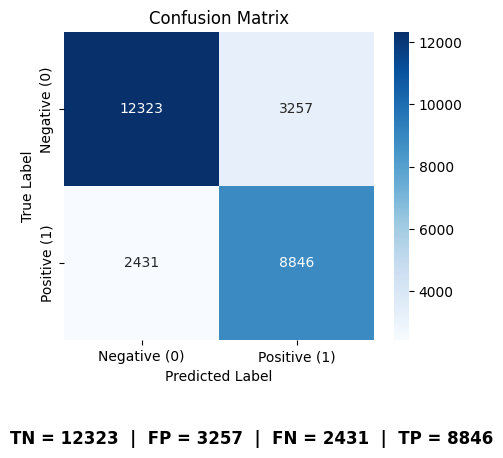

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(total_test_labels, binary_preds)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.figtext(0.5, -0.15, f'TN = {tn}  |  FP = {fp}  |  FN = {fn}  |  TP = {tp}',ha='center', fontsize=12, weight='bold')

plt.show()


In [73]:
model_dim = 256
num_heads = 4
num_layers = 2
dropout = 0.1
batch_size =  256
epochs = 200

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [75]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
test_dataset = TensorDataset(X_test[: ,0],X_test[:,1],X_test[:,2],X_test[:,3], y_test)

In [76]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import torch
import numpy as np
import os

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = "/kaggle/working/"
os.makedirs(save_dir, exist_ok=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Starting Fold {fold + 1}/{k_folds}")
  
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)


    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


    model = TransformerModel(vocab_size=vocab_size,model_dim=256, num_heads=4, num_layers=2, dropout=0.1).to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)

    best_val_loss = float("inf")
    patience_counter = 0
    patience = 6
    threshold = 0.4256
    save_path = os.path.join(save_dir, f"best_model_classif_fold_{fold + 1}.pth")

    for epoch in range(epochs):
        #train loop
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in train_loader:
            pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        total_train_preds = torch.cat(total_train_preds).numpy()
        total_train_labels = torch.cat(total_train_labels).numpy()
        train_auroc = roc_auc_score(total_train_labels, total_train_preds)
        train_f1 = f1_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_precision = precision_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_recall = recall_score(total_train_labels, total_train_preds > threshold, zero_division=0)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, AUROC: {train_auroc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

        #val loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in val_loader:
                pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
                loss = criterion(outputs, scores)
                val_loss += loss.item()
                total_val_preds.append(torch.sigmoid(outputs).cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        total_val_preds = torch.cat(total_val_preds).numpy()
        total_val_labels = torch.cat(total_val_labels).numpy()
        val_auroc = roc_auc_score(total_val_labels, total_val_preds)
        val_f1 = f1_score(total_val_labels, total_val_preds > threshold)
        val_precision = precision_score(total_val_labels, total_val_preds > threshold)
        val_recall = recall_score(total_val_labels, total_val_preds > threshold)

        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        #earlystop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved for Fold {fold+1} with Val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val auroc: {best_val_loss:.4f}")
                break

    print(f"========== Completed Fold {fold + 1}/{k_folds} ==========")

Starting Fold 1/5
Epoch 1, Train Loss: 0.5692, AUROC: 0.7586, F1: 0.6420, Precision: 0.6129, Recall: 0.6741
Epoch 1, Val Loss: 0.5532, AUROC: 0.7837, F1: 0.6747, Precision: 0.6191, Recall: 0.7413
Best model saved for Fold 1 with Val loss: 0.5532
Epoch 2, Train Loss: 0.5186, AUROC: 0.8091, F1: 0.6871, Precision: 0.6631, Recall: 0.7130
Epoch 2, Val Loss: 0.5284, AUROC: 0.8092, F1: 0.7009, Precision: 0.6190, Recall: 0.8076
Best model saved for Fold 1 with Val loss: 0.5284
Epoch 3, Train Loss: 0.4996, AUROC: 0.8256, F1: 0.7028, Precision: 0.6786, Recall: 0.7288
Epoch 3, Val Loss: 0.5413, AUROC: 0.8183, F1: 0.7024, Precision: 0.5913, Recall: 0.8649
Epoch 4, Train Loss: 0.4848, AUROC: 0.8377, F1: 0.7161, Precision: 0.6936, Recall: 0.7401
Epoch 4, Val Loss: 0.4948, AUROC: 0.8311, F1: 0.7185, Precision: 0.6697, Recall: 0.7750
Best model saved for Fold 1 with Val loss: 0.4948
Epoch 5, Train Loss: 0.4721, AUROC: 0.8472, F1: 0.7267, Precision: 0.7018, Recall: 0.7536
Epoch 5, Val Loss: 0.5024, AUR

In [77]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

save_dir = "/kaggle/working/"
k_folds = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
for fold in range(k_folds):
    model = TransformerModel(vocab_size,model_dim, num_heads, num_layers, dropout)
    model.to(device)
    model_path = os.path.join(save_dir, f"best_model_classif_fold_{fold + 1}.pth")
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    models.append(model)

total_preds = []
total_labels = []
total_loss = 0
criterion = nn.BCEWithLogitsLoss()
threshold = 0.4256
total_loss = 0
total_preds = []
total_labels = []

with torch.no_grad():
    for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in test_loader:
        pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)

        outputs = torch.zeros_like(scores, dtype=torch.float32).to(device)
        for model in models:
            outputs += model(pep_ids, mhc_ids,pep_mask,mhc_mask).squeeze()
        outputs /= len(models)

        loss = criterion(outputs, scores)
        total_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().numpy()

        total_preds.append(probs)
        total_labels.append(scores.cpu().numpy())

total_preds = np.concatenate(total_preds)
total_labels = np.concatenate(total_labels)


test_loss = total_loss / len(test_loader)
test_auroc = roc_auc_score(total_labels, total_preds)
test_f1 = f1_score(total_labels, total_preds > threshold)
test_precision = precision_score(total_labels, total_preds > threshold)
test_recall = recall_score(total_labels, total_preds > threshold)

print("Ensemble Test Metrics:")
print(f"Loss: {test_loss:.4f}, AUC ROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")



Ensemble Test Metrics:
Loss: 0.4090, AUC ROC: 0.8898, F1: 0.7763, Precision: 0.7473, Recall: 0.8076


In [78]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix)

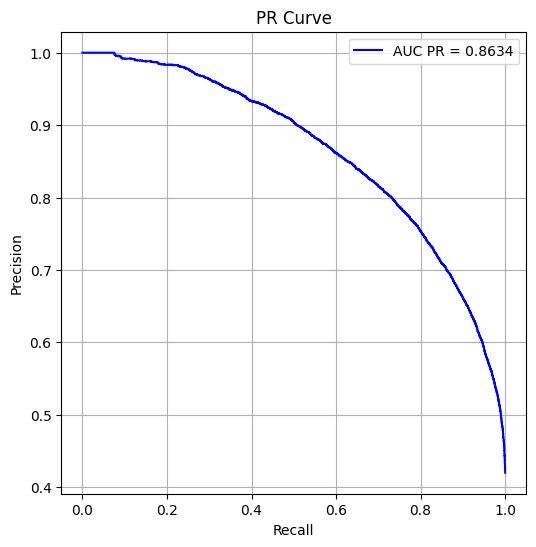

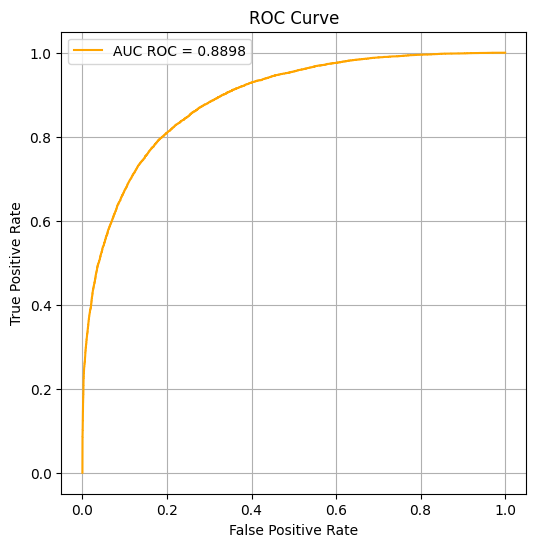

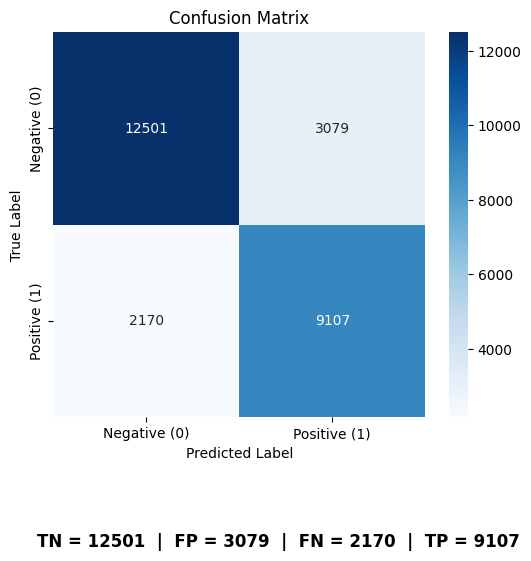

In [79]:
precision, recall, _ = precision_recall_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
test_pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', label=f'AUC PR = {test_pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend()
plt.grid()
plt.show()

fpr, tpr, _ = roc_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', label=f'AUC ROC = {test_auroc:.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

conf_matrix = confusion_matrix(total_labels, total_preds > threshold)
tn, fp, fn, tp = conf_matrix.ravel()
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.figtext(0.5, -0.15, f'TN = {tn}  |  FP = {fp}  |  FN = {fn}  |  TP = {tp}',ha='center', fontsize=12, weight='bold')
plt.show()
